<a href="https://colab.research.google.com/github/venkatesh1226/CMPE255-DataMining/blob/main/Hierarchical_youtube_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Extracting the Dataset

In [ ]:
import zipfile

# Path to the zip file and extraction directory
zip_file_path = '/content/drive/MyDrive/DM_Assignment_06/youtube-comments.zip'
extraction_path = '/content/drive/MyDrive/DM_Assignment_06/youtube-comments'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


Step 2: Load the Dataset

In [ ]:
import pandas as pd

# Replace with the path to the extracted file
file_path = '/content/drive/MyDrive/DM_Assignment_06/youtube-comments/youtoxic_english_1000.csv'
df_comments = pd.read_csv(file_path)

# Display the first few rows
print(df_comments.head())


              CommentId      VideoId  \
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI   
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive  \
0  If only people would just take a step back and...    False      False   
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  \
0     False          False      False         False     False          False   
1     False          False      False         False     False          False   
2     False          False       True         False     False 

The dataset contains a mix of textual data (Text) and several binary classification labels (like IsToxic, IsAbusive, etc.).

Since hierarchical clustering is typically applied to numerical data, we need to convert the text data into a numerical format. One common approach is to use TF-IDF (Term Frequency-Inverse Document Frequency) to transform the text into a feature vector.

Step 1: Text Preprocessing

Before transforming the text data, it's a good practice to preprocess it. This involves cleaning the text, removing unnecessary characters, and possibly lemmatizing or stemming the words.


In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for cleaning the text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Remove new lines
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function to the Text column
df_comments['CleanedText'] = df_comments['Text'].apply(clean_text)


Step 2: Feature Extraction using TF-IDF

Next, we'll transform the cleaned text data into a numerical format using TF-IDF.

In [ ]:
# Initializing the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # you can adjust max_features based on your dataset

# Fitting and transforming the cleaned text
tfidf_matrix = tfidf_vectorizer.fit_transform(df_comments['CleanedText'])

Step 3: Hierarchical Clustering

Now, we'll perform hierarchical clustering on the TF-IDF matrix.

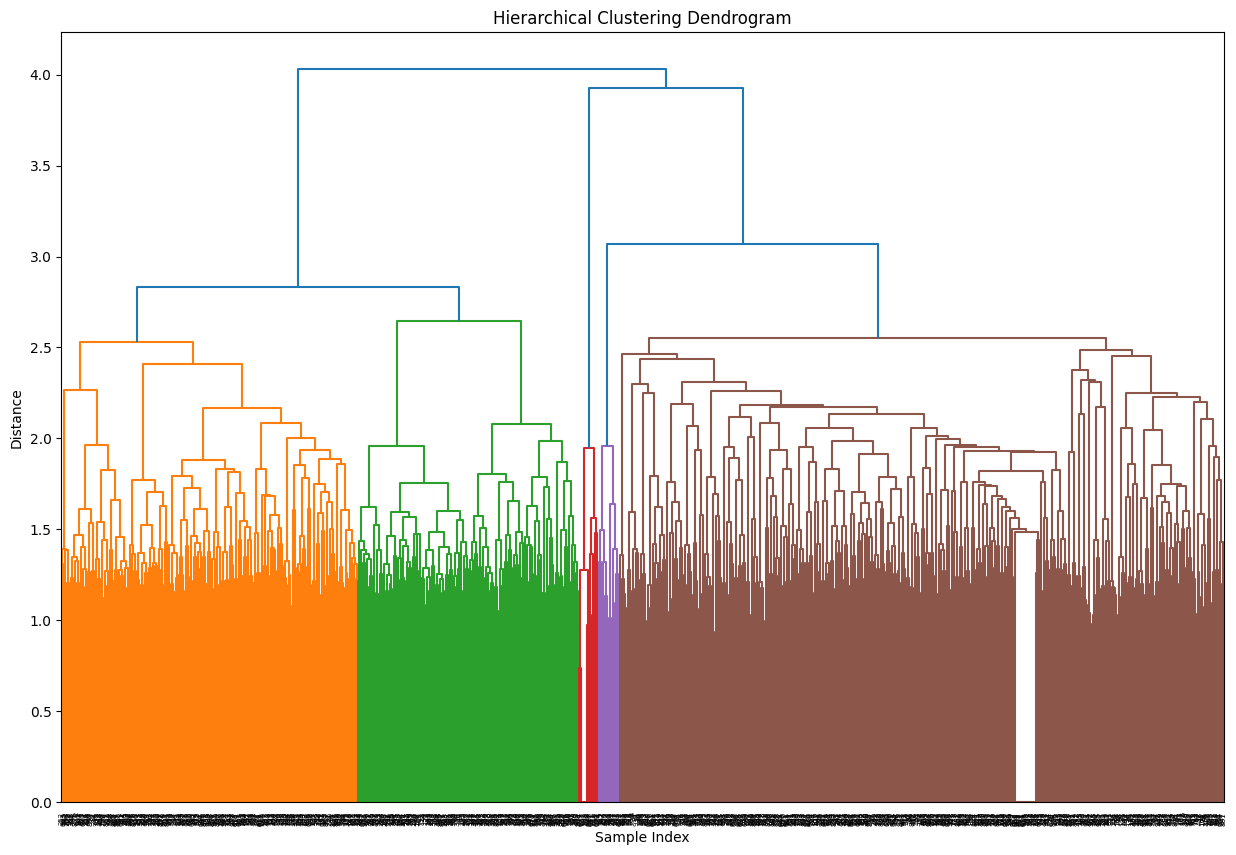

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Using the linkage method for hierarchical clustering
Z = linkage(tfidf_matrix.todense(), method='ward')

# Plotting the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


1. Advanced Text Preprocessing
Further preprocessing of the text data can help improve the quality of the features you're extracting. This can include:

Stopword Removal: Removing common words that don't contribute much meaning.

Stemming/Lemmatization: Reducing words to their base or root form.

Handling Negations: Sometimes, the presence of negations (like "not good") can change the sentiment of a phrase, which might be relevant depending on your analysis goals.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and wordnet data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and get stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

# Apply the advanced cleaning function
df_comments['AdvancedCleanedText'] = df_comments['Text'].apply(advanced_clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


2. Dimensionality Reduction

Before applying hierarchical clustering, we need to reduce the dimensionality of your TF-IDF matrix, especially if it's very large. This can be done using techniques like PCA (Principal Component Analysis) or Truncated SVD (Singular Value Decomposition), which is more suitable for sparse matrices like TF-IDF.

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Apply Truncated SVD
svd = TruncatedSVD(n_components=100)  # You can adjust the number of components
tfidf_reduced = svd.fit_transform(tfidf_matrix)


Analyzing Clusters

After clustering, you can analyze the clusters to understand the nature of comments grouped together. For example, you can examine the most common words in each cluster or the proportion of comments labeled as 'Toxic' or 'Abusive' in each cluster.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Assign cluster labels based on 5 clusters
cluster_labels = fcluster(Z, 5, criterion='maxclust')

# Add cluster labels to the DataFrame
df_comments['Cluster'] = cluster_labels


In [ ]:
# Print the number of comments in each cluster
print(df_comments['Cluster'].value_counts())

# Analyze the clusters
for i in range(1, 6):  # Assuming your cluster labels are 1, 2, 3, 4, 5
    print(f"\nCluster {i}:")
    cluster_subset = df_comments[df_comments['Cluster'] == i]

    # Example analysis: Mean of different labels
    mean_values = cluster_subset[['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative']].mean()
    print(mean_values)


5    520
1    255
2    190
4     18
3     17
Name: Cluster, dtype: int64

Cluster 1:
IsToxic          0.501961
IsAbusive        0.345098
IsThreat         0.023529
IsProvocative    0.192157
dtype: float64

Cluster 2:
IsToxic          0.436842
IsAbusive        0.347368
IsThreat         0.010526
IsProvocative    0.136842
dtype: float64

Cluster 3:
IsToxic          1.000000
IsAbusive        0.941176
IsThreat         0.058824
IsProvocative    0.882353
dtype: float64

Cluster 4:
IsToxic          0.0
IsAbusive        0.0
IsThreat         0.0
IsProvocative    0.0
dtype: float64

Cluster 5:
IsToxic          0.450000
IsAbusive        0.351923
IsThreat         0.023077
IsProvocative    0.136538
dtype: float64


In [ ]:


# Add cluster labels to the original DataFrame
df_comments['Cluster'] = cluster_labels

# Analyze clusters
for cluster in set(cluster_labels):
    print(f"Cluster {cluster}:")
    cluster_comments = df_comments[df_comments['Cluster'] == cluster]
    # Perform your analysis, e.g., counting labels, extracting key words, etc.


Cluster 1:
Cluster 2:
Cluster 3:
Cluster 4:
Cluster 5:


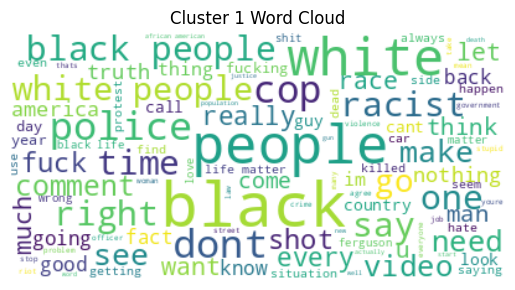

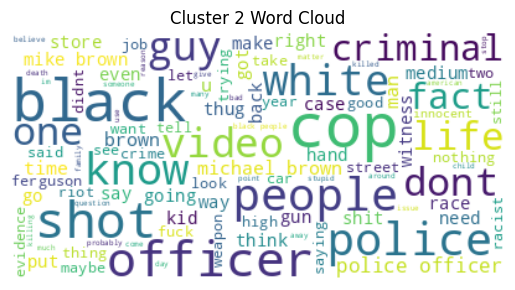

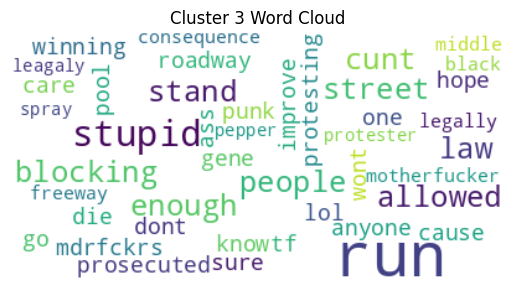

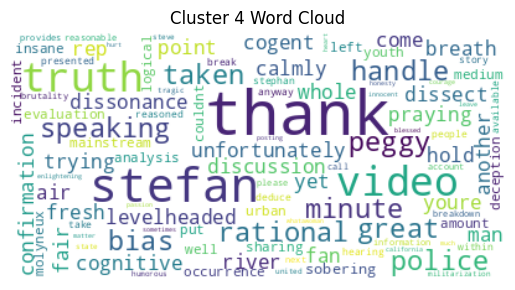

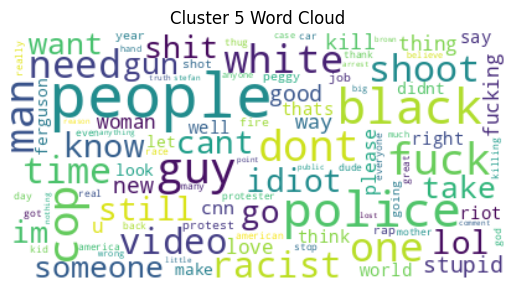

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud for each cluster
for i in range(1, 6):
    plt.figure()
    text = ' '.join(df_comments[df_comments['Cluster'] == i]['AdvancedCleanedText'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Cluster {i} Word Cloud')
    plt.show()
